<a href="https://colab.research.google.com/github/antoinemarchal/ROHSA/blob/master/ROHSApy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook ROHSA 

### About this notebook

This is a notebook to show you how to install and run ROHSA. It was built to run on [Google Colab](https://colab.research.google.com) but should work on many systems. This [link](https://colab.research.google.com/drive/1i5ehl1VVpe0JKxFEq0lscIo-ml5uWWtm) should find a version of this notebook launched on colab.

#### Notebook Authors:
Joshua Peek, Antoine Marchal

## Installing ROHSA
[ROHSA](https://github.com/antoinemarchal/ROHSA) is a code for decomposing PPV emission cubes into Gaussians. It is written in FORTRAN90 and thus needs to be installed via make. We clone the repository from github, change to the correct directory and make.

##Model from ROHSA
\begin{equation}
  \tilde T_B\big(v_z, \theta(r)\big) = \sum_{n=1}^{N} 
  G\big(v_z, \theta_n(r)\big)
\end{equation}

with $\theta(r) = \big(\theta_1(r), \dots, \theta_n(r)\big)$ and where

\begin{equation}
  G\big(v_z, \theta_n(r)\big) = a_n(r) \exp
  \left( - \frac{\big(v_z - \mu_n(r)\big)^2}{2 \sigma_n(r)^2} \right)
\end{equation}

is parametrized by $\theta_n = \big(a_n, \mu_n, \sigma_n\big)$ with
$a_n \geq 0$ being the amplitude, $\mu_{n}$ the position, and
$\sigma_{n}$ the standard deviation 2D maps of the $n$-th Gaussian
profile across the plan of sky. 

The residual is

\begin{equation}
  L\big(v_z, \theta(r)\big) = \tilde T_B\big(v_z, \theta(r)\big) 
  - T_B(v_z, r).
\end{equation}

The cost function that includes the sum of the squares of the residual is

\begin{equation}
  Q(\theta) = \frac{1}{2} \, \sum_{v_z, r} 
  \left(\frac{L\big(v_z, \theta(r)\big)}{\Sigma(r)}\right)^2
\end{equation}

where $\Sigma$ is the standard deviation 2D map of the noise assumed
without spatial correlation.

The regularization terms are

\begin{equation}
  R(\theta,m) = \frac{1}{2} \, \sum_{n=1}^N \lambda_{a} \|D a_n\|_2^2 +
  \lambda_{\mu} \|D \mu_n\|_2^2 + \lambda_{\sigma} \|D \sigma_n\|_2^2 +
  \lambda'_{\sigma} \|\sigma_n - m_n\|_2^2
\end{equation}

with $m = (m_1, \dots, m_N)$ and $a_n \geq 0$, $\forall \, n \in [1, \dots, N]$ and where D is a matrix performing the 2D convolution using the kernel d and $\lambda_a$, $\lambda_{\mu}$, and $\lambda_{\sigma}$ are hyper-parameters than tune the balance between the different terms.

\begin{equation}
  d = \begin{bmatrix}
  0 & -1 & 0 \\
  -1 & 4 & -1 \\
  0 & -1 & 0 \\
  \end{bmatrix}
\end{equation}

The full cost function is then

\begin{align}
  J(\theta, m) = Q(\theta) + R(\theta,m).
\end{align}

Finally, the minimizer is 

\begin{equation}
[\hat \theta, \hat m] = \underset{\theta,m}{\text{argmin}}\ J(\theta,m),
\ \text{wrt. } a_n \geq 0,\ \forall \, n \in [1, \dots, N]
\end{equation}

In [55]:
!git clone https://github.com/antoinemarchal/ROHSA.git ROHSA
import os
os.chdir('ROHSA/src')
!make
os.chdir('../../')

fatal: destination path 'ROHSA' already exists and is not an empty directory.
gfortran blas.o lbfgsb.o linpack.o timer.o mod_constants.o mod_convert.o mod_inout.o mod_array.o mod_optimize.o mod_optimize_lym.o mod_minimize.o mod_functions.o mod_start.o mod_rohsa.o main.o -lm -g -O2  -o ROHSA


## Getting Data
Our example data comes from the GHIGLS Survey from Martin et al. 2015.  

In [56]:
!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_DFN_Tb.fits

--2020-12-18 02:57:28--  https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_DFN_Tb.fits
Resolving www.cita.utoronto.ca (www.cita.utoronto.ca)... 128.100.76.44
Connecting to www.cita.utoronto.ca (www.cita.utoronto.ca)|128.100.76.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2485440 (2.4M) [image/fits]
Saving to: ‘GHIGLS_DFN_Tb.fits.1’

GHIGLS_DFN_Tb.fits. 100%[===================>]   2.37M  2.64MB/s    in 0.9s    

2020-12-18 02:57:30 (2.64 MB/s) - ‘GHIGLS_DFN_Tb.fits.1’ saved [2485440/2485440]



## Getting started with ROHSApy

### Installation

In [57]:
!pip install ROHSApy

 ### Load data + Visualizing the integrated column density map


In [58]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA

fitsname = "GHIGLS_DFN_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[0][150:350,:16,:16]

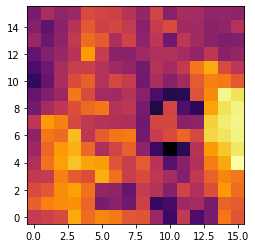

In [59]:
plt.figure()
plt.imshow(np.sum(cube,0), origin="lower", cmap="inferno")

### Generate files for ROHSA with your data
Here we run cube2dat that converts the fits file to a dat file readable by FORTRAN and generate a parameters file to run the code.

In [65]:
filename = "GHIGLS_DFN_Tb.dat" #@param
fileout = "GHIGLS_DFN_Tb_gauss_run_0.dat" #@param
filename_noise = ''
n_gauss = 6           #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_mu = 100       #@param {type:"slider", min:0, max:1000, step:1}
lambda_sig = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_var_sig = 0.   #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of Gaussians for the fit of the mean spectrum                                                                                                                                                                                                                                                       
sig_init = 4.         # dispersion of Gaussians for the fit of the mean spectrum
lb_sig_init = 1.      # lower limit on sigma for the fit of the mean spectrum
ub_sig_init = 12.     # upper limit on sigma for the fit of the mean spectrum
lb_sig = 1.
ub_sig = 100.                                                                                                                                                                                                                                                                
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 800         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
noise = ".false."     # if false - STD map computed by ROHSA between lstd and ustd                                                                                                                                                                                                           
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 

core = ROHSA(cube)            
core.cube2dat(filename=filename)
core.gen_parameters(filename=filename, 
                    fileout=fileout,  
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    amp_fact_init=amp_fact_init,
                    sig_init=sig_init,
                    lb_sig_init=lb_sig_init,
                    ub_sig_init=ub_sig_init,
                    lb_sig=lb_sig,
                    ub_sig=ub_sig,
                    noise=noise,
                    maxiter=maxiter,
                    lstd=lstd,
                    ustd=ustd,
                    iprint_init=iprint_init,
                    iprint=iprint,
                    save_grid=save_grid)


Generate GHIGLS_DFN_Tb.dat file readable by fortran
Generate parameters.txt file


### Running ROHSA
Here we run ROHSA on the data. This is invoking the parameter file parameters.txt. 
Note : If you want to use core.run() method, you have to add your executable in your own .bashrc - 
Here we use directly ROHSA from src

In [66]:
!./ROHSA/src/ROHSA parameters.txt

 -------------------------------------------------------------------------
18 December 2020   3:02:16.523 AM
 
   ____     ___    _   _   ____       _    
  |  _ \   / _ \  | | | | / ___|     / \   
  | |_) | | | | | | |_| | \___ \    / _ \  
  |  _ <  | |_| | |  _  |  ___) |  / ___ \ 
  |_| \_\  \___/  |_| |_| |____/  /_/   \_\ 
 
  Version 1.2.1
  ROHSA is released as open source code
  Check out the documentation: https://antoinemarchal.github.io/ROHSA/
 
 run: ./ROHSA parameters.txt
 -------------------------------------------------------------------------
 filename = 'GHIGLS_DFN_Tb.dat'
 fileout = 'GHIGLS_DFN_Tb_gauss_run_0.dat'
 timeout = 'timestep.dat'
  
 ______Parameters_____
 n_gauss =            6
 n_gauss_add =            0
 lambda_amp =    100.00000000000000     
 lambda_mu =    100.00000000000000     
 lambda_sig =    100.00000000000000     
 lambda_var_amp =    0.0000000000000000     
 lambda_var_mu =    0.0000000000000000     
 lambda_var_sig =    0.0000000000000000    

### Reading the result of ROHSA
read_gaussian() method allows you to read the output file generated by ROHSA. The structure of the cube is the following : 

* dim 1 = Gaussian parameters / Ordering : amplitude - position - dispersion

* dim 2 and dim 3 = spatial axis

Note that position and dispersion are in pixel unit


In [67]:
gaussian = core.read_gaussian("GHIGLS_DFN_Tb_gauss_run_0.dat")
print("dim cube = " + str(gaussian.shape))

model = core.return_result_cube(gaussian=gaussian)

amplitude = gaussian[0::3]
position = gaussian[1::3]
dispersion = gaussian[2::3]

integral = amplitude * dispersion

Opening data file
dim cube = (18, 16, 16)


### Plot model of the integrated column density map

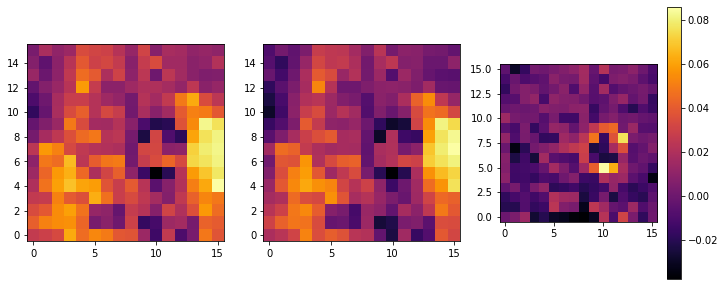

In [68]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(np.sum(cube,0), origin="lower", cmap="inferno")
plt.subplot(1,3,2)
plt.imshow(np.sum(model,0), origin="lower", cmap="inferno")
plt.subplot(1,3,3)
plt.imshow((np.sum(model,0)-np.sum(cube,0))/np.sum(model,0), origin="lower", cmap="inferno")
plt.colorbar()


### Plot the first Gaussian component
Here we plot the amplitude, the position and the dispersion of the first Gaussian + a random spectum of the cube.

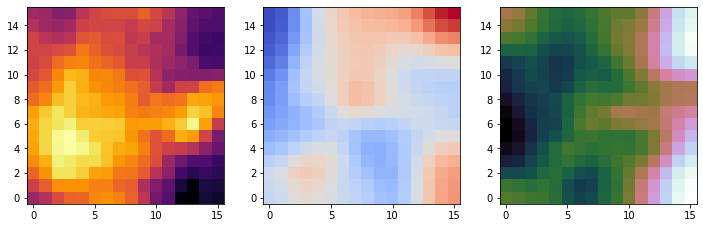

In [69]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(amplitude[0], origin="lower", cmap="inferno")
plt.subplot(1,3,2)
plt.imshow(position[0], origin="lower", cmap="coolwarm")
plt.subplot(1,3,3)
plt.imshow(dispersion[0], origin="lower", cmap="cubehelix")


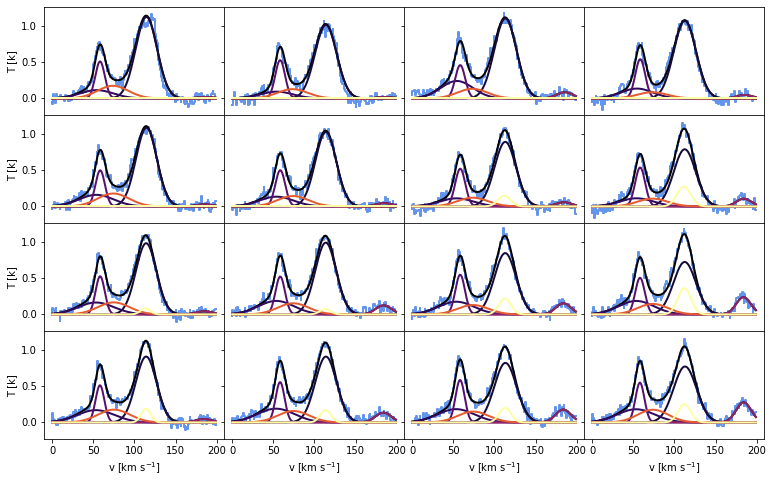

In [70]:
#Plot mosaic spectra                                                                                                                                                                 
pvalues = np.logspace(-1, 0, len(integral))
pmin = pvalues[0]
pmax = pvalues[-1]

def norm(pval):
    return (pval - pmin) / float(pmax - pmin)

ny = 4; nx = 4
center_y = int(cube.shape[2]/2); center_x = int(cube.shape[1]/2)
x = np.arange(cube.shape[0])
cb = "magenta"
cw = "crimson"
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10.,6.))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, top=1, bottom=0)
for i in np.arange(ny):
    for j in np.arange(nx):
        axs[i][j].step(x, cube[:,center_y+i,center_x+j], color='cornflowerblue', linewidth=2.)
        axs[i][j].plot(x, model[:,center_y+i,center_x+j], linestyle="-", linewidth=2., color="k")
        for k in range(len(integral)):
            axs[i][j].plot(x, core.gauss(x, gaussian[0::3][k][center_y+i,center_x+j],
                                            gaussian[1::3][k][center_y+i,center_x+j], 
                                            gaussian[2::3][k][center_y+i,center_x+j]),
                           linewidth=2., color=plt.cm.inferno(pvalues[k]))
        if j == 0: axs[i][j].set_ylabel(r'T [k]')
        axs[i][j].set_xlabel(r'v [km s$^{-1}$]')
# plt.savefig("plot/" + 'mosaic_spectra_all.png', format='png', bbox_inches='tight', pad_inches=0.02)


###Enjoy ! And please contact me for any question related to ROHSA